[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1In2mAIVCV57szBqVPETY9tHOZyidwOwH?usp=sharing)

<a name="factor_investing"></a>
# Factor Investing with Regression

This notebook explores the concept of factor investing using regression analysis. We employ the Fama-French 5-Factor model to understand the relationship between specific factors and asset returns. The core of the analysis involves performing regression analysis with two different models:

* Ordinary Least Squares (LS) regression
* Robust Huber regression

We use cross-validation to train and evaluate these models, aiming to quantify the exposure of an asset to the five factors and compare the performance and estimated coefficients between the standard and robust regression approaches.

## Table of Contents
- [Factor Investing with Regression](#factor_investing)
- [Basic Preparation](#basic_preparation)
- [FF5 Data Processing](#ff5_data_processing)
    - [Factors Correlation](#factors_correlation)
- [Data Download](#data_download)
- [FF5 regression](#ff5_regression)
- [Get Model Coefficient](#get_model_coefficient)

<a name="basic_preparation"></a>
# Basic Preparation

In [1]:
%%capture
try:
    import pandas as pd
    ff5_factors_csv_df
except:
    !wget "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
    !unzip "F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
    !rm "F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
    !pip install --upgrade yfinance
finally:
    ff5_factors_csv_df = pd.read_csv("F-F_Research_Data_5_Factors_2x3_daily.csv", skiprows=3)
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import yfinance as yf
    from sklearn.model_selection import KFold
    from sklearn.linear_model import LinearRegression, HuberRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import statsmodels.formula.api as sm
    import statsmodels
    import cvxpy as cvx
    from datetime import datetime
    from IPython.display import display, Latex

    import warnings
    warnings.filterwarnings('ignore')

<a name="ff5_data_processing"></a>
# FF5 Data Processing

This part of the notebook focuses on preparing the raw Fama-French 5-Factor data for analysis. It involves loading the downloaded data into a structured format (a Pandas DataFrame), handling potential missing values, and ensuring the data is properly indexed by date. The function defined here specifically processes the data to a usable format, including converting the date column to datetime objects and filtering the data to a relevant time period for the analysis.

In [2]:
def process_FF_csv(df, start_date, period = 3):
    """
    Processes the Pandas DataFrame downloaded from Ken French's website.

    Args:
        df (pd.DataFrame): The input Pandas DataFrame.  It's assumed that the first column
                           contains dates in the format YYYYMMDD and is currently unnamed.
        start_date (str): The start date in the format 'YYYYMMDD'.
        period (int): The number of periods in a year.  For example, 12 for monthly data.

    Returns:
        pd.DataFrame: The processed Pandas DataFrame with the 'Date' column as the datetime index,
                      missing values removed, and filtered to include data up to the specified end date.
    """
    df = df.copy()
    df.dropna(inplace=True)
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df.set_index('Date', inplace=True)
    try:
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
    except ValueError as e:
        raise ValueError(f"Error converting date index to datetime. Check date format. Original error: {e}") from e

    # Calculate the end date based on the start date and period
    start_date_dt = pd.to_datetime(start_date, format='%Y%m%d')
    end_date_dt = start_date_dt + pd.DateOffset(years=period)
    # Filter the DataFrame to include only the data up to the end date
    df = df[(df.index >= start_date_dt) & (df.index <= end_date_dt)]
    print(f"Processed dataframe. Dataframe period: {pd.to_datetime(df.index[0], format = '%Y%m%d').strftime('%Y-%m-%d')} - {pd.to_datetime(df.index[-1], format = '%Y%m%d').strftime('%Y-%m-%d')}")
    return df

start_date = '20200101'
ff5_factors_df1 = process_FF_csv(ff5_factors_csv_df.copy(), start_date, 3)
ff5_factors_df1

Processed dataframe. Dataframe period: 2020-01-02 - 2022-12-30


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2020-01-02,0.86,-0.97,-0.34,0.23,-0.22,0.006
2020-01-03,-0.67,0.29,0.01,-0.14,-0.17,0.006
2020-01-06,0.36,-0.22,-0.55,-0.16,-0.31,0.006
2020-01-07,-0.19,-0.04,-0.26,-0.13,-0.31,0.006
2020-01-08,0.47,-0.18,-0.64,-0.21,-0.15,0.006
...,...,...,...,...,...,...
2022-12-23,0.52,-0.35,1.16,0.86,0.54,0.016
2022-12-27,-0.50,-0.42,1.43,1.15,1.35,0.016
2022-12-28,-1.24,-0.30,-0.29,-0.93,-0.08,0.016


<a name="factors_correlation"></a>
## Factors Correlation

This section investigates the relationships between the different factors within the Fama-French 5-Factor model. By calculating and visualizing the correlation matrix of the factor returns (excluding the risk-free rate), we can assess the degree to which these factors move together. Understanding the correlations between factors is important for portfolio diversification and for interpreting the results of the regression analysis.


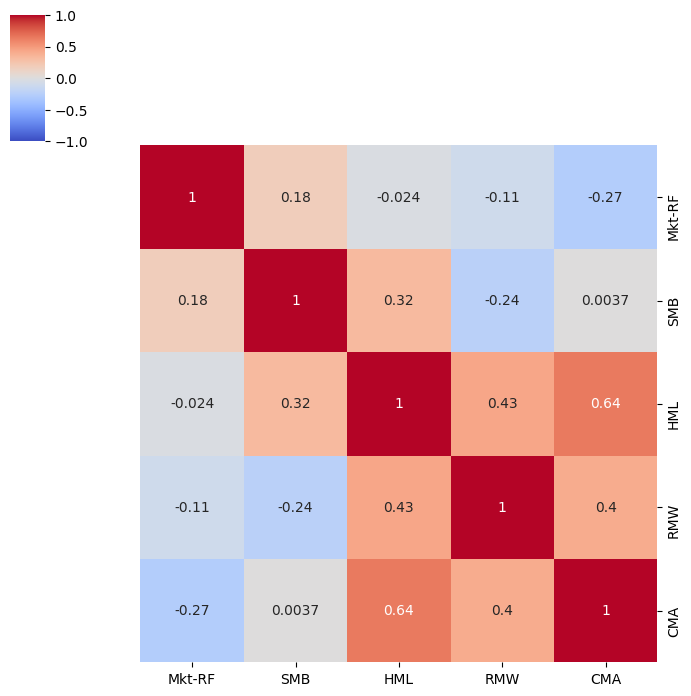

In [3]:
ff5_factors_changes_df = ff5_factors_df1.copy().drop(columns=['RF']).diff().dropna()
ff5_factors_changes_corr = ff5_factors_changes_df.corr()
heatmap = sns.clustermap(
    ff5_factors_changes_corr,
    row_cluster=False,  # Do not cluster the rows
    col_cluster=False,
    vmin=-1,           # Set the minimum value for the color scale to -1
    vmax=1,            # Set the maximum value for the color scale to 1
    cmap='coolwarm',   # Use the 'coolwarm' colormap for coloring the heatmap
    annot=True,
    annot_kws={"size": 10},
    figsize=(7, 7) # Annotate the heatmap with the correlation values
)

It is observed that Mkt-RF and SMB have low correlation with the others, where they are near 0 correlation with the rest variables. This is a good sign as variables that are not correlated can provide more information to the model, and reduce redundant variables. HML and RMW seem to be relatively poor when compared to the rest, as they show high correlation with the others. Correlations of 0.64, 0.43 are a bit high when comparing to the others, and we may need help from PCA in order to produce better variables.

<a name="data_download"></a>
# Data Download

In [4]:
data = yf.download('AAPL', start=pd.to_datetime(ff5_factors_changes_df.index[0], format = '%Y%m%d').strftime('%Y-%m-%d'), end=pd.to_datetime(ff5_factors_changes_df.index[-1], format = '%Y%m%d').strftime('%Y-%m-%d'))['Close'].pct_change().dropna()
regression_df = pd.concat([ff5_factors_df1.copy(),data.copy()], axis = 1).dropna()

[*********************100%***********************]  1 of 1 completed


In [5]:
regression_df

,Mkt-RF,SMB,HML,RMW,CMA,RF,AAPL
Date,,,,,,,
2020-01-06,0.36,-0.22,-0.55,-0.16,-0.31,0.006,0.007968
2020-01-07,-0.19,-0.04,-0.26,-0.13,-0.31,0.006,-0.004703
2020-01-08,0.47,-0.18,-0.64,-0.21,-0.15,0.006,0.016086
2020-01-09,0.65,-0.71,-0.48,-0.15,0.07,0.006,0.021241
2020-01-10,-0.34,-0.27,-0.34,0.05,-0.07,0.006,0.002261
...,...,...,...,...,...,...,...
2022-12-22,-1.52,0.22,0.38,-0.13,0.89,0.016,-0.023773
2022-12-23,0.52,-0.35,1.16,0.86,0.54,0.016,-0.002798
2022-12-27,-0.50,-0.42,1.43,1.15,1.35,0.016,-0.013878


<a name="ff5_regression"></a>
# FF5 regression

This is the core analytical section of the notebook. It performs regression analysis using the Fama-French 5-Factor model. The code implements a cross-validation approach (specifically, K-Fold cross-validation) to train and evaluate both a standard Ordinary Least Squares (LS) regression model and a Robust regression model (HuberRegressor). The goal is to determine how well the five factors explain the variations in the asset's returns and to compare the performance and estimated coefficients of the two regression methods.

In [6]:
# Assuming 'regression_df' contains your data
X = regression_df[['Mkt-RF','SMB', 'HML', 'RMW', 'CMA']].copy()
y = regression_df['AAPL'].copy() - regression_df['RF'].copy()

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to store results
ls_coefs = []         # List of dicts for LS coefficients
robust_coefs = []     # List of dicts for Robust coefficients

ls_r2_scores = []     # List of R-squared scores for LS
robust_r2_scores = [] # List of R-squared scores for Robust

# Additional metrics
ls_mae_scores = []
robust_mae_scores = []

ls_mse_scores = []
robust_mse_scores = []

ls_rmse_scores = []
robust_rmse_scores = []

# New lists to store intercepts
ff5_ls_intercepts = []
ff5_robust_intercepts = []

# Loop through the folds
for fold_idx, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Least Squares Regression
    ls_model = LinearRegression()
    ls_model.fit(X_train, y_train)
    y_pred_ls = ls_model.predict(X_test)

    ls_r2_scores.append(ls_model.score(X_test, y_test))
    ls_coefs.append(dict(zip(X.columns, ls_model.coef_)))
    ff5_ls_intercepts.append(ls_model.intercept_)


    ls_mae_scores.append(mean_absolute_error(y_test, y_pred_ls))
    ls_mse_scores.append(mean_squared_error(y_test, y_pred_ls))
    ls_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_ls)))

    # Robust Regression (HuberRegressor)
    robust_model = HuberRegressor()
    robust_model.fit(X_train, y_train)
    y_pred_robust = robust_model.predict(X_test)

    robust_r2_scores.append(robust_model.score(X_test, y_test))
    robust_coefs.append(dict(zip(X.columns, robust_model.coef_)))
    ff5_robust_intercepts.append(robust_model.intercept_)

    robust_mae_scores.append(mean_absolute_error(y_test, y_pred_robust))
    robust_mse_scores.append(mean_squared_error(y_test, y_pred_robust))
    robust_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_robust)))

# Convert coefficient lists to DataFrames
ls_coefs_df = pd.DataFrame(ls_coefs)
robust_coefs_df = pd.DataFrame(robust_coefs)

# Summarize coefficients: min, max, mean
def summarize_coefficients(df):
    return pd.DataFrame({
        'min': df.min(),
        'max': df.max(),
        'mean': df.mean(),
        #'range': df.max() - df.min()
    })

ff5_ls_summary = summarize_coefficients(ls_coefs_df)
ff5_robust_summary = summarize_coefficients(robust_coefs_df)

# Summarize R-squared scores and new metrics
ff5_metrics_summary = pd.DataFrame({
    'R2_min': [np.min(ls_r2_scores), np.min(robust_r2_scores)],
    'R2_max': [np.max(ls_r2_scores), np.max(robust_r2_scores)],
    'R2_mean': [np.mean(ls_r2_scores), np.mean(robust_r2_scores)],

    'MAE_min': [np.min(ls_mae_scores), np.min(robust_mae_scores)],
    'MAE_max': [np.max(ls_mae_scores), np.max(robust_mae_scores)],
    'MAE_mean': [np.mean(ls_mae_scores), np.mean(robust_mae_scores)],

    'MSE_min': [np.min(ls_mse_scores), np.min(robust_mse_scores)],
    'MSE_max': [np.max(ls_mse_scores), np.max(robust_mse_scores)],
    'MSE_mean': [np.mean(ls_mse_scores), np.mean(robust_mse_scores)],

    'RMSE_min': [np.min(ls_rmse_scores), np.min(robust_rmse_scores)],
    'RMSE_max': [np.max(ls_rmse_scores), np.max(robust_rmse_scores)],
    'RMSE_mean': [np.mean(ls_rmse_scores), np.mean(robust_rmse_scores)],
}, index=['LS', 'Robust'])

In [7]:
print("LS Regression Coefficients:\n")
ff5_ls_summary

LS Regression Coefficients:



,min,max,mean
Mkt-RF,0.012960,0.013285,0.013094
SMB,-0.002270,-0.001309,-0.001715
HML,-0.008004,-0.006957,-0.007414
RMW,0.003898,0.004389,0.004089
CMA,0.008812,0.011135,0.010028


In [8]:
print("Robust Regression Coefficients:\n")
ff5_robust_summary

Robust Regression Coefficients:



,min,max,mean
Mkt-RF,0.012949,0.013254,0.013101
SMB,-0.002067,-0.001094,-0.001436
HML,-0.007560,-0.006733,-0.007009
RMW,0.003962,0.004271,0.004132
CMA,0.008941,0.010547,0.009712


<a name="get_model_coefficient"></a>
# Get Model Coefficient

This section presents the estimated coefficients from the regression models in a clear and interpretable format. The function defined here takes the summarized coefficients and intercepts from the cross-validation results and constructs a mathematical formula representation of the regression equation using LaTeX. This provides a concise way to display the relationship between the asset's expected excess return and the Fama-French factors based on the fitted models.

In [9]:
def get_model_formula_latex(ff5, ff5_intercept):
    # Get mean coefficients
    ff5_coefs = ff5['mean']

    # Construct the LaTeX formula string
    ff5_formula_latex = (
        r"$ \text{Expected Excess Return} = "
        f"{ff5_coefs['Mkt-RF']:.4f} \cdot (Mkt-RF) + "
        f"{ff5_coefs['SMB']:.4f} \cdot (SMB) + "
        f"{ff5_coefs['HML']:.4f} \cdot (HML) + "
        f"{ff5_coefs['RMW']:.4f} \cdot (RMW) + "
        f"{ff5_coefs['CMA']:.4f} \cdot (CMA) + "
        f"{np.mean(ff5_intercept):.5f} $"
    )
    return ff5_formula_latex

# Usage example with your variables
# Assuming ff5_ls_summary, ff5_ls_intercepts, etc. are defined
ff5_ls_formula_latex = get_model_formula_latex(ff5_ls_summary, ff5_ls_intercepts)
print("FF5 LS Regression Formula (LaTeX):")
display(Latex(ff5_ls_formula_latex))

ff5_robust_formula_latex = get_model_formula_latex(ff5_robust_summary, ff5_robust_intercepts)
print("\nFF5 Robust Regression Formula (LaTeX):")
display(Latex(ff5_robust_formula_latex))

FF5 LS Regression Formula (LaTeX):


<IPython.core.display.Latex object>


FF5 Robust Regression Formula (LaTeX):


<IPython.core.display.Latex object>